ToggleButtons(description='Metric: ', index=4, options=('Speed', 'Accuracy', 'Speed & Accuracy', 'Learning Curve', 'Speed vs. Accuracy'), value='Speed vs. Accuracy')

HBox(children=(Select(description='Of Task: ', index=1, options=('Both Tasks', 'Sentence Transcription', 'Q&A Conversation', 'Between Tasks'), value='Sentence Transcription'), Select(description='Of Subject: ', options=('All Subjects', '#1', '#2', '#3', 'Between Subjects'), value='All Subjects')))

<IPython.core.display.Javascript object>


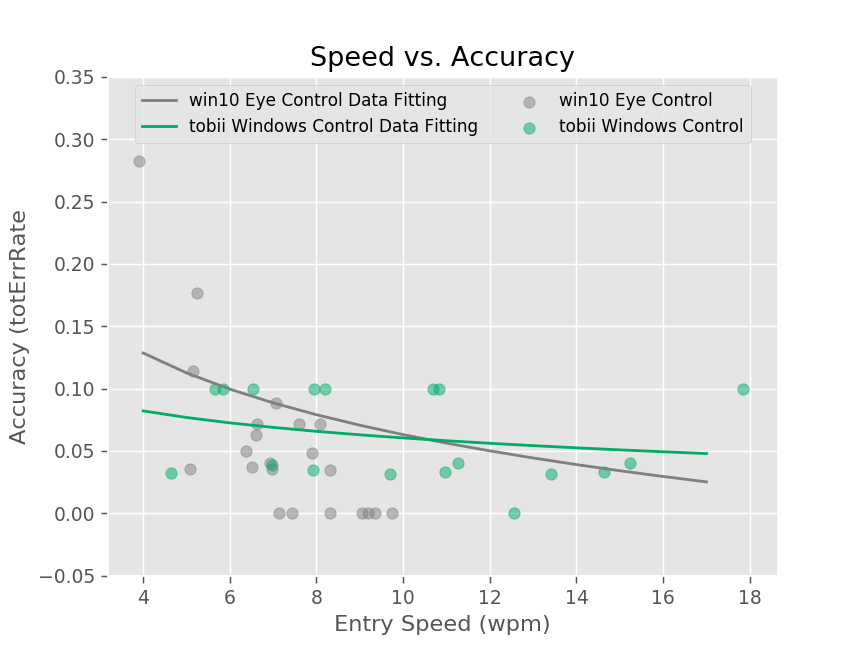

In [72]:
%matplotlib notebook	
import csv
from __future__ import print_function
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import numpy as np

class Sentence:
	# class variables here
	def __init__(self, subject, task, sentenceNo, testing):
		# instance variables here
		self.subject = subject
		self.task = task			# 0: transcribe; 1: free conversation
		self.sentenceNo = sentenceNo
		self.testing = testing		# 0: practice; 1: test
		self.keyboard = 0			# 0: win EyeControl; 1: tobii WinControl
		self.wpm = 0.0
		self.totErrRate = 0.0

def readSentences(argFilename, argSentences):
	with open('RawData/'+argFilename+'.csv') as csvDataFile:
		csvReader = csv.reader(csvDataFile)
		next(csvReader, None)
		next(csvReader, None)
		for row in csvReader:
			if 'Transcribe' in argFilename:
				argSentences.append(Sentence(int(argFilename[0])-1, 0, int(row[0]), int(row[1])))
			elif 'FreeConv' in argFilename:
				argSentences.append(Sentence(int(argFilename[0])-1, 1, int(row[0]), 1))
			# exclude exceptions that the test subject didn't enter anything and skipped this sentence			
			if int(row[2]) != 0:
				sentences[-1].wpm = int(row[4])+int(row[5])*0.1**(len(row[5]))
				sentences[-1].totErrRate = int(row[-14])*0.1**(len(row[-14]))
			else:
				sentences[-1].wpm = 0
				sentences[-1].totErrRate = 1
			if 'winEyeControl' in argFilename:
				sentences[-1].keyboard = 0
			elif 'tobiiWinControl' in argFilename:
				sentences[-1].keyboard = 1				

def onChange_metric(b):
	if b['type']=='change' and b['name']=='value':
		clearCache()
		extractSentences()

def onChange_task(change):
	if change['type']=='change' and change['name']=='value':
		clearCache()
		extractSentences()

def onChange_subject(change):
	if change['type']=='change' and change['name']=='value':
		clearCache()
		extractSentences()

def extractSentences():
	for item in sentences:
		if item.testing == 1:
			if ('1' in contrOfSubject.value and item.subject == 0) or ('2' in contrOfSubject.value and item.subject == 1) or ('3' in contrOfSubject.value and item.subject == 2):
				if ('Transcription' in contrOfTask.value and item.task == 0) or ('Conversation' in contrOfTask.value and item.task == 1) or ('Both' in contrOfTask.value) or ('Between' in contrOfTask.value):
					perSubjTaskWpm[(int(contrOfSubject.value[1])-1)*amountTask*amountKeyboard+item.task*amountKeyboard + item.keyboard].append(item.wpm)
					perSubjTaskTotErrRate[(int(contrOfSubject.value[1])-1)*amountTask*amountKeyboard+item.task*amountKeyboard + item.keyboard].append(item.totErrRate)
					perSubjTaskSentenceNo[(int(contrOfSubject.value[1])-1)*amountTask*amountKeyboard+item.task*amountKeyboard + item.keyboard].append(item.sentenceNo)
			elif ('All' in contrOfSubject.value) or ('Between' in contrOfSubject.value):
				if ('Transcription' in contrOfTask.value and item.task == 0) or ('Conversation' in contrOfTask.value and item.task == 1) or ('Both' in contrOfTask.value) or ('Between' in contrOfTask.value):
					perSubjTaskWpm[item.subject*amountTask*amountKeyboard+item.task*amountKeyboard + item.keyboard].append(item.wpm)
					perSubjTaskTotErrRate[item.subject*amountTask*amountKeyboard+item.task*amountKeyboard + item.keyboard].append(item.totErrRate)
					perSubjTaskSentenceNo[item.subject*amountTask*amountKeyboard+item.task*amountKeyboard + item.keyboard].append(item.sentenceNo)

	if 'Speed' == contrMetric.value:
		plotSpeed()
	elif 'Accuracy' == contrMetric.value:
		plotAccuracy()
	elif 'Speed & Accuracy' == contrMetric.value:
		plotSpeedNAccuracy()
	elif 'Learning' in contrMetric.value:
		plotLearningCurve()
	elif 'Speed vs. Accuracy' == contrMetric.value:
		plotSpeedVsAccuracy()

def clearCache():
	clear_output(wait=True)
	display(contrMetric, widgets.HBox([contrOfTask, contrOfSubject]))
	for i in range(amountSubject * amountTask * amountKeyboard):
		del perSubjTaskWpm[i][:], perSubjTaskTotErrRate[i][:], perSubjTaskSentenceNo[i][:]
	contrOfTask.disabled = False
	contrOfSubject.disabled =False

def plotSpeed():
	fig, ax = plt.subplots()
	ax.set(title=contrOfSubject.value+' speed during '+contrOfTask.value, ylabel='Entry Speed (wpm)')
	plt.ylim(-1,18)						
	if 'Between' not in contrOfSubject.value:
		if 'Between' not in contrOfTask.value:
			if (('Conversation' in contrOfTask.value) and ('1' in contrOfSubject.value)) != 1:
				yWpm_MS, yWpm_Tobii = ([] for k in range(amountKeyboard))
				for i in range(len(perSubjTaskWpm)):
					for j in range(len(perSubjTaskWpm[i])):
						if i%amountKeyboard:
							yWpm_MS.append(perSubjTaskWpm[i][j])
						else:
							yWpm_Tobii.append(perSubjTaskWpm[i][j])
				bp_MS = plt.boxplot(yWpm_MS, positions=[1], showfliers=True, patch_artist=True, boxprops=dict(facecolor=color[0]), medianprops=dict(linewidth=1, linestyle=None, color='yellow'))
				bp_Tobii = plt.boxplot(yWpm_Tobii, positions=[2], showfliers=True, patch_artist=True, boxprops=dict(facecolor=color[1]), medianprops=dict(linewidth=1, linestyle=None, color='yellow'))
				plt.xlim(0,3)	
				plt.xticks([1,2], ('Windows\nEye Control','Tobii\nWindows Control'))
		# typing speed comparison between tasks
		else:
			yWpm_MS, yWpm_Tobii = ([[], []] for i in range(amountKeyboard))
			for j in range(len(perSubjTaskWpm)):
				if j%amountKeyboard == 0:
					if j%(amountKeyboard*amountTask) < amountKeyboard:
						for k in range(len(perSubjTaskWpm[j])):
							yWpm_MS[0].append(perSubjTaskWpm[j][k])
					else:
						for k in range(len(perSubjTaskWpm[j])):
							yWpm_MS[1].append(perSubjTaskWpm[j][k])
				else:
					if j%(amountKeyboard*amountTask) <= amountKeyboard:
						for k in range(len(perSubjTaskWpm[j])):
							yWpm_Tobii[0].append(perSubjTaskWpm[j][k])
					else:
						for k in range(len(perSubjTaskWpm[j])):
							yWpm_Tobii[1].append(perSubjTaskWpm[j][k])
			bp_MS = plt.boxplot(yWpm_MS, positions=[1,1.5], showfliers=True, patch_artist=True, boxprops=dict(facecolor=color[0]), medianprops=dict(linewidth=1, linestyle=None, color='yellow'))
			bp_Tobii = plt.boxplot(yWpm_Tobii, positions=[2.5,3], showfliers=True, patch_artist=True, boxprops=dict(facecolor=color[1]), medianprops=dict(linewidth=1, linestyle=None, color='yellow'))
			plt.xlim(0.5,3.5)	
			plt.xticks([1.25,2.75], ('Windows\nEye Control','Tobii\nWindows Control'))
	# typing speed comparison between subjects
	else:
		if 'Between' not in contrOfTask.value:
			yWpm_MS, yWpm_Tobii = ([[], [], []] for i in range(2))
			for j in range(len(perSubjTaskWpm)):	
				for k in range(len(perSubjTaskWpm[j])):
					if j%amountKeyboard:
						yWpm_MS[j//(amountKeyboard*amountTask)].append(perSubjTaskWpm[j][k])
					else:
						yWpm_Tobii[j//(amountKeyboard*amountTask)].append(perSubjTaskWpm[j][k])
			bp_MS = plt.boxplot(yWpm_MS, positions=[1,2,3], showfliers=True, patch_artist=True, boxprops=dict(facecolor=color[0]), medianprops=dict(linewidth=1, linestyle=None, color='yellow'))
			bp_Tobii = plt.boxplot(yWpm_Tobii, positions=[4.5,5.5,6.5], showfliers=True, patch_artist=True, boxprops=dict(facecolor=color[1]), medianprops=dict(linewidth=1, linestyle=None, color='yellow'))
			plt.xlim(0.5,7)
			plt.xticks([1,2,3,4.5,5.5,6.5], ('','Windows\nEye Control','','','Tobii\nWindows Control',''))
	fig.savefig('plotSpeed_'+contrOfSubject.value+'_'+contrOfTask.value+'.png', bbox_inches='tight')

def plotAccuracy():
	if 'Transcription' in contrOfTask.value:
		fig, ax = plt.subplots()
		ax.set(title=contrOfSubject.value+' accuracy during '+contrOfTask.value, ylabel='Accuracy (totErrRate)')
		plt.ylim(-0.05,0.55)				
		if 'Between' not in contrOfSubject.value:
				yTotErrRate_MS, yTotErrRate_Tobii = ([] for k in range(amountKeyboard))
				for i in range(len(perSubjTaskTotErrRate)):
					for j in range(len(perSubjTaskTotErrRate[i])):
						if i%amountKeyboard:
							yTotErrRate_MS.append(perSubjTaskTotErrRate[i][j])
						else:
							yTotErrRate_Tobii.append(perSubjTaskTotErrRate[i][j])
				bp_MS = plt.boxplot(yTotErrRate_MS, positions=[1], showfliers=True, patch_artist=True, boxprops=dict(facecolor=color[0]), medianprops=dict(linewidth=1, linestyle=None, color='yellow'))
				bp_Tobii = plt.boxplot(yTotErrRate_Tobii, positions=[2], showfliers=True, patch_artist=True, boxprops=dict(facecolor=color[1]), medianprops=dict(linewidth=1, linestyle=None, color='yellow'))
				plt.xlim(0,3)	
				plt.xticks([1,2], ('Windows\nEye Control','Tobii\nWindows Control'))
		# typing accuracy comparison between subjects
		else:
			yTotErrRate_MS, yTotErrRate_Tobii = ([[], [], []] for i in range(2))
			for j in range(len(perSubjTaskTotErrRate)):	
				for k in range(len(perSubjTaskTotErrRate[j])):
					if j%amountKeyboard:
						yTotErrRate_MS[j//(amountKeyboard*amountTask)].append(perSubjTaskTotErrRate[j][k])
					else:
						yTotErrRate_Tobii[j//(amountKeyboard*amountTask)].append(perSubjTaskTotErrRate[j][k])
			bp_MS = plt.boxplot(yTotErrRate_MS, positions=[1,2,3], showfliers=True, patch_artist=True, boxprops=dict(facecolor=color[0]), medianprops=dict(linewidth=1, linestyle=None, color='yellow'))
			bp_Tobii = plt.boxplot(yTotErrRate_Tobii, positions=[4.5,5.5,6.5], showfliers=True, patch_artist=True, boxprops=dict(facecolor=color[1]), medianprops=dict(linewidth=1, linestyle=None, color='yellow'))
			plt.xlim(0.5,7)
			plt.xticks([1,2,3,4.5,5.5,6.5], ('','Windows\nEye Control','','','Tobii\nWindows Control',''))
		fig.savefig('plotAccuracy_'+contrOfSubject.value+'_'+contrOfTask.value+'.png', bbox_inches='tight')

def plotLearningCurve():
	if ('Transcription' in contrOfTask.value):
		yWpm_MS, yWpm_Tobii, xSentenceNo_MS, xSentenceNo_Tobii, yWpmMean_MS, yWpmMean_Tobii, zTotErrRate_MS, zTotErrRate_Tobii= ([] for i in range(8))
		try:
			if int(contrOfSubject.value[1]) in [1,2,3]:
				indexSubj = [(int(contrOfSubject.value[1])-1)*amountTask*amountKeyboard]
		except ValueError:
			if ('All' in contrOfSubject.value) or ('Between' in contrOfSubject.value):
				indexSubj = []
				for i in range(amountSubject):
					indexSubj.append(i*amountTask*amountKeyboard)

		plotVariables = [yWpm_MS, yWpm_Tobii, xSentenceNo_MS, xSentenceNo_Tobii, zTotErrRate_MS, zTotErrRate_Tobii]
		meanBuffer_MS, meanBuffer_Tobii = ([] for i in range(2))
		for j in range(len(indexSubj)):
			for k in range(len(plotVariables)):
				plotVariables[k].append([])
			for i in range(len(perSubjTaskSentenceNo[indexSubj[j]])):
				xSentenceNo_MS[j].append(perSubjTaskSentenceNo[indexSubj[j]][i])
				yWpm_MS[j].append(perSubjTaskWpm[indexSubj[j]][i])
				zTotErrRate_MS[j].append(perSubjTaskTotErrRate[indexSubj[j]][i])
			for i in range(len(perSubjTaskSentenceNo[indexSubj[j]+1])):
				xSentenceNo_Tobii[j].append(perSubjTaskSentenceNo[indexSubj[j]+1][i])
				yWpm_Tobii[j].append(perSubjTaskWpm[indexSubj[j]+1][i])
				zTotErrRate_Tobii.append(perSubjTaskTotErrRate[indexSubj[j]][i])	

	fig, ax = plt.subplots()
	if len(indexSubj) == 1:
		plt.plot(xSentenceNo_MS[0],yWpm_MS[0],'o-',color=color[0],alpha=0.3,label=labelKeybd[0])		
		plt.plot(xSentenceNo_Tobii[0],yWpm_Tobii[0],'o-',color=color[1],alpha=0.3,label=labelKeybd[1])

	elif len(indexSubj) > 1:
		for i in range(10):
			for j in range(len(indexSubj)):
				try:
					meanBuffer_MS.append(yWpm_MS[j][i])
					meanBuffer_Tobii.append(yWpm_Tobii[j][i])
				except IndexError:
					pass		
			try:
				yWpmMean_MS.append(np.mean(meanBuffer_MS))
				yWpmMean_Tobii.append(np.mean(meanBuffer_Tobii))
				del meanBuffer_MS[:]
				del meanBuffer_Tobii[:]
			except IndexError:
				pass
		plt.plot([i for i in range(4,len(yWpmMean_MS)+4)], yWpmMean_MS, color=color[0], label=labelKeybd[0])
		plt.plot([i for i in range(4,len(yWpmMean_Tobii)+4)], yWpmMean_Tobii, color=color[1], label=labelKeybd[1])
	for i in range(len(indexSubj)):
		plt.scatter(xSentenceNo_MS[i],yWpm_MS[i],c=zTotErrRate_MS[i])


	ax.set(title='Learning curve', xlabel='Sentence no.', ylabel='Entry speed (wpm)')
	plt.set_cmap('gray')	# high error rate deepen the scatter color
	ax.legend(loc='upper center', ncol=2, shadow=True)
	plt.ylim(0, 22)
	fig.savefig('plotLearningCurve_'+contrOfSubject.value+'.png', bbox_inches='tight')

def plotSpeedNAccuracy():
	pass

def plotSpeedVsAccuracy():
	contrOfTask.value = 'Sentence Transcription'
	contrOfSubject.value = 'All Subjects'
	contrOfTask.disabled = True
	contrOfSubject.disabled = True
	xWpm_MS, xWpm_Tobii, yTotErrRate_MS, yTotErrRate_Tobii = ([] for i in range(4))
	for i in range(len(perSubjTaskWpm)):
		if i%amountKeyboard == 0:
			for j in range(len(perSubjTaskWpm[i])):
				if perSubjTaskWpm[i][j] != 0 and perSubjTaskTotErrRate != 1:
					xWpm_MS.append(perSubjTaskWpm[i][j])
					yTotErrRate_MS.append(perSubjTaskTotErrRate[i][j])
		else:
			for j in range(len(perSubjTaskWpm[i])):
				if perSubjTaskWpm[i][j] != 0 and perSubjTaskTotErrRate != 1:				
					xWpm_Tobii.append(perSubjTaskWpm[i][j])
					yTotErrRate_Tobii.append(perSubjTaskTotErrRate[i][j])
	fig, ax = plt.subplots()
	ax.set(title='Speed vs. Accuracy', xlabel='Entry Speed (wpm)', ylabel='Accuracy (totErrRate')	
	plt.scatter(xWpm_MS,yTotErrRate_MS,color=color[0],alpha=0.5,label=labelKeybd[0])
	z_MS = np.polyfit(np.log(xWpm_MS),yTotErrRate_MS,1)
	xFit_MS = range(4,18)
	yFit_MS = z_MS[0]*np.log(xFit_MS)+z_MS[1]
	plt.plot(xFit_MS,yFit_MS,color=color[0],label=labelKeybd[0]+' Data Fitting')
	plt.scatter(xWpm_Tobii,yTotErrRate_Tobii,color=color[1],alpha=0.5,label=labelKeybd[1])
	z_Tobii = np.polyfit(np.log(xWpm_Tobii),yTotErrRate_Tobii,1)
	xFit_Tobii = range(4,18)
	yFit_Tobii = z_Tobii[0]*np.log(xFit_Tobii)+z_Tobii[1]
	plt.plot(xFit_Tobii,yFit_Tobii,color=color[1],label=labelKeybd[1]+' Data Fitting')
	plt.ylim(-0.05,0.35)
	ax.legend(loc='upper center',ncol=2,fontsize=9)	
	fig.savefig('plotSpeed_VS_Accuracy.png', bbox_inches='tight')
	# should have R-squared here

if __name__ == "__main__":
	sentences = []	
	amountSubject = 3
	amountTask = 2
	amountKeyboard = 2
	color = ['gray', '#01ac66']		# dynavox green
	labelKeybd = ['win10 Eye Control', 'tobii Windows Control']
	labelKeybdMean = ['win10 Eye Control Mean', 'tobii Windows Control Mean']

	perSubjTaskWpm, perSubjTaskTotErrRate, perSubjTaskSentenceNo = ([[] for i in range(amountSubject * amountTask * amountKeyboard)] for j in range(3))	

	# readSentences()
	filenames = ['1Greta_s1Transcribe_winEyeControl', '1Greta_s2Transcribe_tobiiWinControl', '2Carlota_s1Transcribe_winEyeControl', '2Carlota_s2FreeConv_winEyeControl', '2Carlota_s3Transcribe_tobiiWinControl',
				'2Carlota_s4FreeConv_tobiiWinControl', '3Barbara_s1Transcribe_tobiiWinControl', '3Barbara_s2FreeConv_tobiiWinControl', '3Barbara_s3Transcribe_winEyeControl', '3Barbara_s4FreeConv_winEyeControl']
	for item in filenames:
		readSentences(item, sentences)

	# define UI controls
	contrMetric = widgets.ToggleButtons(
		options=['Speed', 'Accuracy', 'Speed & Accuracy', 'Learning Curve', 'Speed vs. Accuracy'],
		description = 'Metric: ',
		value = 'Speed',
		disabled = False
		)
	contrOfTask = widgets.Select(
		options = ['Both Tasks', 'Sentence Transcription', 'Q&A Conversation', 'Between Tasks'],
		description = 'Of Task: ',
		value = 'Sentence Transcription',
		disabled = False
		)
	contrOfSubject = widgets.Select(
		options = ['All Subjects', '#1', '#2', '#3', 'Between Subjects'],
		description = 'Of Subject: ',
		value = 'All Subjects',
		disabled = False
		)
	display(contrMetric, widgets.HBox([contrOfTask, contrOfSubject]))
	contrMetric.observe(onChange_metric)
	contrOfTask.observe(onChange_task)
	contrOfSubject.observe(onChange_subject)